# Introduction to LangGraph - Module 1: Introduction

# Pre-requisites

In [15]:
!pip install -qU langgraph langchain_openai langchain_core langgraph-prebuilt

# Simplest Graph

## State

The **State** schema of the graph serves as the input schema for all Nodes and Edges in the graph.

We can use `TypedDict` class from `typing` module as our schema for now, which provides typ hints for the keys:

In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## Nodes

The **Nodes** of the graph are just *python functions*.

The first positional argument is the state as we defined above.
- Because we defined the state as a `TypedDict` with schema shown above, each node can access the key, `graph_state`, with `state['graph_state']`.
- Each node returns a new value of the state key `graph_state`.

By default, the new value returned by each node will **OVERRIDE** the prior state value.

In [3]:
def node_1(state):
    print('---Node 1---')
    return {'graph_state': state['graph_state'] + "I am"}

def node_2(state):
    print('---Node 2---')
    return {'graph_state': state['graph_state'] + " happy!"}

def node_3(state):
    print('---Node 3---')
    return {'graph_state': state['graph_state'] + " sad!"}

## Edges

**Edges** of the graph connect the nodes. They are directed from one node to another node.

**Conditional edges** are used if we want to *optionally* route between nodes. They are implemented as functions that return the next node to visit based upon some logic.

In [4]:
import random
from typing import Literal

def decide_mood(state) -> Literal['node_2', 'node_3']:
    user_input = state['graph_state']

    # assume 50/50 split between nodes 2 and 3
    if random.random() < 0.5:
        return 'node_2'
    else:
        return 'node_3'

## Graph construction

We can build the graph using our defined edge and node components above. We will use the `StateGraph` class to set up a builder. The `StateGraph` graph class is initialized with the `State` class we defined above.

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Bulid graph
builder = StateGraph(State)
builder.add_node('node_1', node_1)
builder.add_node('node_2', node_2)
builder.add_node('node_3', node_3)

# Logic
builder.add_edge(START, 'node_1')
builder.add_conditional_edges(
    'node_1',
    decide_mood, # the returned values are the string name for our two nodes
)
builder.add_edge('node_2', END)
builder.add_edge('node_3', END)

# Build graph
graph = builder.compile()

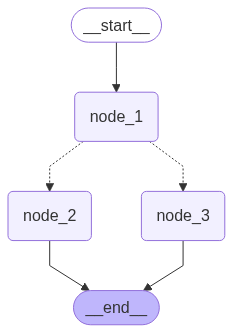

In [8]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph invocation

The compiled graph implements the **runnable** protocol, which provides a standard way to execute LangChain components. We can use `invoke` method to execute the graph with our defined state.

Here our `State` class requires us to have a key `graph_state` so we need to invoke the graph with the same key:

In [10]:
query = {'graph_state': "Hi there, this is Bin."}

graph.invoke(query)

---Node 1---
---Node 2---


{'graph_state': 'Hi there, this is Bin.I am happy!'}

The `invoke` method runs the entire graph *synchronously. This waits for each step to complete before moving to the next.

# LangGraph Studio

To run LangGraph Studio, we need to make sure our necessary files (`.env`, `agent.py`, `langgraph.json`, and any functions that are imported to `agent.py` are in one folder)

# Chain

## Messages

Chat models can use `messages` objects, which capture different roles within a conversation.

LangChain supports
- `HumanMessage`
- `AIMessage`
- `SystemMessage`
- `ToolMessage`

Each message can be supplied with a few things:
- `content`: content of the message
- `name`: optional, a message author
- `response_metadata`: optional, a dictionary of metadata (e.g., often populated by model provider for `AIMessage`)

In [7]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = []
messages.append(AIMessage(content=f"So you said you were researching ocean mammals?", name="Model"))
messages.append(HumanMessage(content=f"Yes, that's right.",name="Bin"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Bin"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Bin

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Bin

I want to learn about the best place to see Orcas in the US.


## Chat Models

In [2]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

We can load a chat model and invoke it with our list of messages.

In [10]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

The returned `result` is an `AIMessage` with specific `response_metadata`:

In [15]:
result

AIMessage(content='If you\'re looking to see orcas (also known as killer whales) in the United States, one of the best places to visit is the Pacific Northwest, specifically the waters around the San Juan Islands in Washington State. These islands are renowned for their orca populations, particularly in the summer months.\n\nHere are a few key locations and tips for orca watching in this region:\n\n1. **San Juan Islands, Washington**: \n   - **Best Time**: The peak season for orca watching is typically from late spring through early fall, with June to September being the best months. \n   - **Tours**: Numerous guided boat tours operate from Friday Harbor on San Juan Island, and they offer the chance to see orcas as well as other marine wildlife.\n   - **Land-Based Viewing**: Lime Kiln Point State Park, also known as "Whale Watch Park," on the west side of San Juan Island, is one of the best land-based locations to spot orcas.\n\n2. **Puget Sound, Washington**: \n   - Orcas can also be 

In [16]:
result.response_metadata

{'token_usage': {'completion_tokens': 347,
  'prompt_tokens': 67,
  'total_tokens': 414,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_07871e2ad8',
 'id': 'chatcmpl-C47aIL8SyYGR6FdtpFTyMHsJYzJIv',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools are useful when we want a model to interact with external systems.

External systems (e.g., APIs) require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema. The model will choose to call a tool based upon the natural language input from the user.

In addition, it will return an output that adheres to the tool's schema.

In [11]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b

    Args:
        a: first int
        b: second int
    """
    return a * b


tools = [multiply]
llm_with_tools = llm.bind_tools(tools)

In [20]:
query = HumanMessage(
    content="What is 3 multiplied by 8",
    name="Bin"
)
messages = [query]

result = llm_with_tools.invoke(messages)

In [22]:
result

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DU8gTw0JSVri7YAUlCLPjWH0', 'function': {'arguments': '{"a":3,"b":8}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff25b2783a', 'id': 'chatcmpl-C47fTE7NR9V4aFrn3vmiLEslyMVzm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--77fbb795-aea7-4973-b8b9-a9d870811beb-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 8}, 'id': 'call_DU8gTw0JSVri7YAUlCLPjWH0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 17, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_rea

The `content` in the returned `result` `AIMessage` object does not have anything but we got `tool_calls` available.

In [21]:
result.tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 8},
  'id': 'call_DU8gTw0JSVri7YAUlCLPjWH0',
  'type': 'tool_call'}]

In [23]:
result.response_metadata

{'token_usage': {'completion_tokens': 17,
  'prompt_tokens': 62,
  'total_tokens': 79,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_ff25b2783a',
 'id': 'chatcmpl-C47fTE7NR9V4aFrn3vmiLEslyMVzm',
 'service_tier': 'default',
 'finish_reason': 'tool_calls',
 'logprobs': None}

## Using messages as state

With the Chat model and tools in place, we can use `messages` object in our graph state.

First we need to define our state `MessagesState` as a `TypedDict` with a single key: `messages`.
- `messages` is simply a list of messages, here `AnyMessage`.

In [4]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage


class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

As we mentioned, each node in the graph will return a new value for our state key `messages`, but this new value will **override** the prior `messages` value.

As our graph runs, we want to append messages to our `messages` state key. This is where the *reducer functions* address this issue.

**Reducers** allow us to specify how state updates are performed. If no reducer function is specified, then it is assumed that updates to the key should *override* it as we saw before. Since we want to append messages, we can use a pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages. We simply annotate our `messages` key with the `add_messages` reducer function as metadata:

In [5]:
from typing import Annotated
from langgraph.graph.message import add_messages


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built `MessagesState`.

`MessagesState` is defined:
- with a pre-build single `messages` key
- a list of `AnyMessage` object
- with an `add_messages` reducer

Now our previous `MessagesState` can be also rewritten as

In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

To see how `add_messages` reducer works in isolation:

In [8]:
# Initial state
initial_msgs = [
    AIMessage(content="Hello! How can I help you?", name='Model'),
    HumanMessage(content="I'm looking for information about LangGraph.", name='Bin')
]

# New message to add
new_msg = AIMessage(content="Sure, I can help with that. What specific topic are you interested in?", name='Model')

# Test `add_messages`
add_messages(initial_msgs, new_msg)

[AIMessage(content='Hello! How can I help you?', additional_kwargs={}, response_metadata={}, name='Model', id='70cd6a96-07fd-4c93-ac03-075f3e634d46'),
 HumanMessage(content="I'm looking for information about LangGraph.", additional_kwargs={}, response_metadata={}, name='Bin', id='4137bceb-360a-4a06-9b60-2b2995d550d3'),
 AIMessage(content='Sure, I can help with that. What specific topic are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='c5a081d6-e99d-4d56-8abe-94a5d777f8bc')]

## Our graph

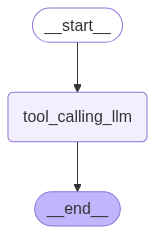

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node('tool_calling_llm', tool_calling_llm)

builder.add_edge(START, 'tool_calling_llm')
builder.add_edge('tool_calling_llm', END)

# Build graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
messages = graph.invoke(
    {'messages': HumanMessage(content='Hello!')}
)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


In [14]:
messages = graph.invoke(
    {"messages": HumanMessage(content="Multiply 2 and 3")}
)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_RYEoFGxy16UPqBVO9amzuBtv)
 Call ID: call_RYEoFGxy16UPqBVO9amzuBtv
  Args:
    a: 2
    b: 3


# Router

A router can route chat models between a direct response or a tool call based upon the user input.

In [16]:
# Set up
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [17]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

We can use the built-in `ToolNode` and pass a list of tools to initialize it.

We will also use the built-in `tools_condition` as our conditional edge. The `tools_condition` will check the latest message/result (`AIMessage`) and
- routes to tool node (`tools` in this case) if the latest message contains a tool call request, or
- routes to `END` if the latest message does not contains a tool call.

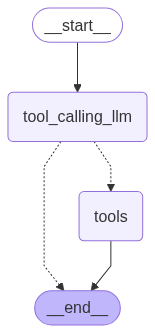

In [18]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Define a tool node (pre-built)
tools = ToolNode([multiply])

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", tools)

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ErNSqdTqYN3d7xehBE5DJeTS)
 Call ID: call_ErNSqdTqYN3d7xehBE5DJeTS
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


Now the graph runs the tool and returns the result with a `ToolMessage`.

In [20]:
messages = [HumanMessage(content="Hello, how are you?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, how are you?
================================== Ai Message ==================================

Hello! I'm just a computer program, so I don't have feelings like humans do, but I'm ready and available to help you with any questions or tasks you have. How can I assist you today?


Now the graph routes to the end directly.

## LangGraph Studio

In the `langgraph.json`, we may the following setting:

```json
{
    "dockerfile_lines": [],
    "graphs": {
        "simple_graph": "./simple.py:graph",
        "router": "./router.py:graph",
        "agent": "./agent.py:graph"
    },
    "env": "./.env"
    "python_version": "3.11",
    "dependencies": [
        "."
    ]
}
```
In the `"graph"` key, this will trace all available graphs we put there, in this case `simple_graph`, `router` and `agent` graphs.

# Agent

In the router example, we invoked the model and, if it chooses to call a tool, we will returned a `ToolMessage` to the user.

What if we simply pass that `ToolMessage` back to the model? We can let it either
- call another tool, or
- respond directly.

This is the intuition behind **ReAct**, a general agent architecture
- **act** - let the model call specific tools
- **observe** - pass the tool output back to the model
- **reason** - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [21]:
# Set up
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

We will use LangSmith for tracing.

In [22]:
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING_V2'] = userdata.get('LANGSMITH_TRACING_V2')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')

Now we create multiple tools in this session.

In [23]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")

# For this session we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Next we create our LLM and prompt it with the overall desired agent behavior.

In [24]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage


# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
)

# Node
def assistant(state: MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_msg] + state['messages'])]}

We used `MessagesState` and define a `Tools` node with our list of tools.

The `assistant` node contains our LLM model with bound tools. We will create a graph with `assistant` and `tools` nodes.

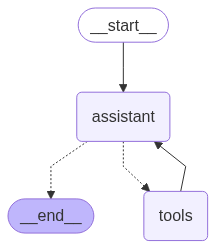

In [25]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

# MAIN CHANGES HERE
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

The main change which is different from the previous graph in the last section is that we add `builder.add_edge("tools", "assistant")` to connect the `tools` *back* to the `assistant` forming a loop:
- After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
- If so, the flow is directed to the `tools` node.
- The `tools` node connects back to `assistant` after tool execution.
- This loop continues as long as the model decides to call tools.
- If the model response is not a tool call, the flow is directed to `END` node, terminating the process.

In [26]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_D3WfEorE1RzK8kVhvO5zki8P)
 Call ID: call_D3WfEorE1RzK8kVhvO5zki8P
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_wxpc5Vx2EikW0ztBKmLF8gKw)
 Call ID: call_wxpc5Vx2EikW0ztBKmLF8gKw
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_hxhgJlqMdbsNcreT3GiiLk44)
 Call ID: call_hxhgJlqMdbsNcreT3GiiLk44
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

# Agent Memory

ReAct Agent is a popular agent architecture. In this section, we will extend our agent by intorducing memory.

In [27]:
# Set up
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING_V2'] = userdata.get('LANGSMITH_TRACING_V2')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')

Same steps to set up LLM and tools.

In [28]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [29]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

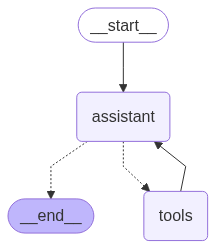

In [30]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

This is the same agent graph we created in the last section.

## Memory

In [31]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_OUeON9pzZoujQ9eHDXd8kB4R)
 Call ID: call_OUeON9pzZoujQ9eHDXd8kB4R
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


In [32]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

It seems like there is a missing value to multiply by 2. Could you please provide the number you want to multiply by 2?


This tells us that the chat does not retain memory of 7 from our intial converstaion. This is because state is transient to a single graph execution. This limits our ability to have multi-turn conversations with interruptions.

We can address this issue by using *persistence*.

LangGraph can use a checkpointer to automatically save the graph state after each step. This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

In [33]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
# compile graph with memory
react_graph_memory = builder.compile(checkpointer=memory)

To use memory, we need to specify a `thread_id`. This `thread_id` will store our collection of graph states.

The checkpointer writes the state at every step of the graph, and then these checknpoints are saved in a thread. We can not access that thread in the future using that `thread_id`.

In [34]:
# Specify a thread
config = {
    'configurable': {'thread_id': "math_1"}
}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({'messages': messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_WucTb66SYzfrsVTDLAmUw5i8)
 Call ID: call_WucTb66SYzfrsVTDLAmUw5i8
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


If we pass the same `thread_id`, then we can proceed from the previous logged state checkpoint:

In [35]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({'messages': messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_WucTb66SYzfrsVTDLAmUw5i8)
 Call ID: call_WucTb66SYzfrsVTDLAmUw5i8
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_L6o8p1PFknA5stqJmMUykzoF)
 Call ID: call_L6o8p1PFknA5stqJmMUykzoF
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

When you multiply 7 b

## LangGraph Studio

When compiling agents in LangGraph Studio, we do not add checkpointers in the graph compile process, because LangGraph Studio is supported by the LangGraph API. The LangGraph API has its own persistence layer. We can check that thread ID in the LangGraph Studio.

# Deployment

`LangGraph` —
- Python and JavaScript library
- Allows creation of agent workflows

`LangGraph API` —
- Bundles the graph code
- Provides a task queue for managing asynchronous operations
- Offers persistence for maintaining state across interactions

`LangGraph Cloud` --
- Hosted service for the LangGraph API
- Allows deployment of graphs from GitHub repositories
- Also provides monitoring and tracing for deployed graphs
- Accessible via a unique URL for each deployment

`LangGraph Studio` --
- Integrated Development Environment (IDE) for LangGraph applications
- Uses the API as its back-end, allowing real-time testing and exploration of graphs
- Can be run locally or with cloud-deployment

`LangGraph SDK` --
- Python library for programmatically interacting with LangGraph graphs
- Provides a consistent interface for working with graphs, whether served locally or in the cloud
- Allows creation of clients, access to assistants, thread management, and execution of runs